In [1]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt 

(780, 500, 3)


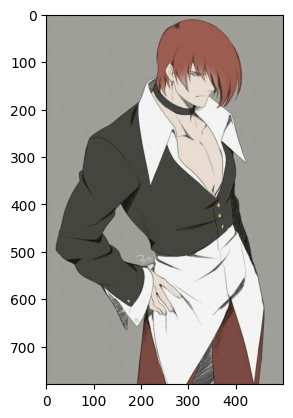

In [2]:
image = plt.imread("IoriYagami.jpg")
plt.imshow(image)
print(image.shape)

(780, 500)


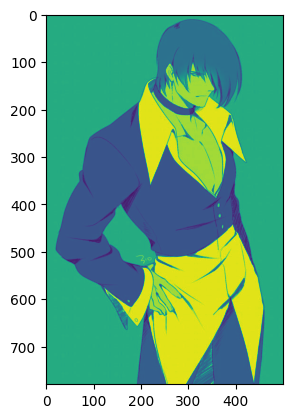

In [3]:
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.imshow(image)
print(image.shape)

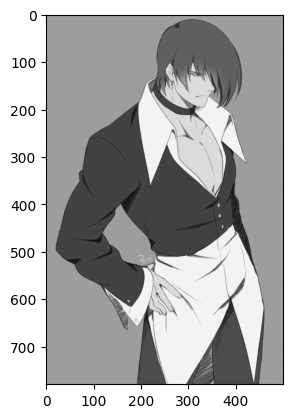

In [4]:
plt.imshow(image, cmap='gray')

In [5]:
# lowPassFilter = np.array([0.5, 0.5])
# highPassFilter = np.array([-0.5, 0.5])

lowPassFilter = np.array([0.7, 0.7])
highPassFilter = np.array([-0.7, 0.7])

In [6]:
def konvolusiBaris(citra, kernel):
   padd = np.pad(citra, ((0,0),(0,1)), 'constant', constant_values=0)
   result = np.zeros(citra.shape).astype(int)
   for i in range(citra.shape[0]):
      for j in range(citra.shape[1]):
         for x in range(len(kernel)):
                  result[i,j] += padd[i, j+x] * kernel[x]
   return result
 
def konvolusiKolom(citra, kernel):
   padd = np.pad(citra, ((0,1),(0,0)), 'constant', constant_values=0)
   result = np.zeros(citra.shape).astype(int)
   for i in range(citra.shape[0]):
      for j in range(citra.shape[1]):
         for x in range(len(kernel)):
                  result[i,j] += padd[i+x, j] * kernel[x]
   return result

In [7]:
def downSamplingBaris(citra):
   result = np.zeros((citra.shape[0]//2,citra.shape[1])).astype(int) 
   x=0
   for i in range(citra.shape[0]//2): 
      for j in range(citra.shape[1]): 
         result[i,j] = citra[x][j]
      x+=2 
   return result
 
def downSamplingKolom(citra):
   result = np.zeros((citra.shape[0],citra.shape[1]//2)).astype(int)
   for i in range(citra.shape[0]): 
      x=0
      for j in range(citra.shape[1]//2): 
         result[i,j] = citra[i][x]
         x+=2 
   return result

In [8]:
def upSamplingBaris(citra):
    result = np.zeros((citra.shape[0]*2,citra.shape[1])).astype(int)
    x=0
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            result[x,j] = citra[i][j]
            result[x+1,j] = citra[i][j]
        x+=2
    return result
 
def upSamplingKolom(citra):
    result = np.zeros((citra.shape[0],citra.shape[1]*2)).astype(int)
    for i in range(citra.shape[0]):
        x=0
        for j in range(citra.shape[1]):
            result[i,x] = citra[i][j]
            result[i,x+1] = citra[i][j]
            x+=2
    return result

# DENGAN INTERPOLASI
# def upSamplingBaris(citra):
#     x = np.arange(citra.shape[1])
#     y = np.arange(citra.shape[0])
#     f = interpolate.interp2d(x, y, citra, kind='quintic')

#     x_new = np.arange(citra.shape[1])
#     y_new = np.arange(0, citra.shape[0], 0.5)
#     result = f(x_new, y_new)
#     return result

# def upSamplingKolom(citra):
#     x = np.arange(citra.shape[1])
#     y = np.arange(citra.shape[0])
#     f = interpolate.interp2d(x, y, citra, kind='quintic')

#     x_new = np.arange(0, citra.shape[1], 0.5)
#     y_new = np.arange(citra.shape[0])
#     result = f(x_new, y_new)
#     return result

In [9]:
def normalize(data, min_target, max_target):
   min_val = np.min(data)
   max_val = np.max(data)
   return (data - min_val) / (max_val - min_val) * (max_target - min_target) + min_target

In [10]:
def pad_image(image, level):
    pad_size = 2**level
    pad_height = pad_size - (image.shape[0] % pad_size) if image.shape[0] % pad_size != 0 else 0
    pad_width = pad_size - (image.shape[1] % pad_size) if image.shape[1] % pad_size != 0 else 0
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='edge')
    return padded_image

In [11]:
def dekomposisi_wavelet(citra, level):
    if level == 0:
        return citra
    konvRowLow = konvolusiBaris(citra, lowPassFilter)
    konvRowHigh = konvolusiBaris(citra, highPassFilter)
    
    downsampleRowLow = downSamplingKolom(konvRowLow)
    downsampleRowHigh = downSamplingKolom(konvRowHigh)
    
    approksimasi = konvolusiKolom(downsampleRowLow, lowPassFilter)
    horizontal = konvolusiKolom(downsampleRowLow, highPassFilter)
    vertical = konvolusiKolom(downsampleRowHigh, lowPassFilter)
    diagonal = konvolusiKolom(downsampleRowHigh, highPassFilter)
    
    detail_approksimasi = downSamplingBaris(approksimasi)
    detail_horizontal = downSamplingBaris(horizontal)
    detail_vertical = downSamplingBaris(vertical)
    detail_diagonal = downSamplingBaris(diagonal)
    
    result_approksimasi = normalize(detail_approksimasi, 0, 255)
    result_horizontal = normalize(detail_horizontal, 0, 255)
    result_vertical = normalize(detail_vertical, 0, 255)
    result_diagonal = normalize(detail_diagonal, 0, 255)
    
    result = np.vstack((np.hstack((result_approksimasi, result_horizontal)), np.hstack((result_vertical, result_diagonal))))
    
    if level > 1:
      result_approksimasi, _, _, _, _ = dekomposisi_wavelet(result_approksimasi, level - 1)
      resized_horizontal = cv.resize(result_horizontal, (result_approksimasi.shape[1], result_approksimasi.shape[0]))
      resized_vertical = cv.resize(result_vertical, (result_approksimasi.shape[1], result_approksimasi.shape[0]))
      resized_diagonal = cv.resize(result_diagonal, (result_approksimasi.shape[1], result_approksimasi.shape[0]))
      result_approksimasi = np.vstack((np.hstack((result_approksimasi, resized_horizontal)), np.hstack((resized_vertical, resized_diagonal))))
      result = np.vstack((np.hstack((result_approksimasi, result_horizontal)), np.hstack((result_vertical, result_diagonal))))
    
    return result_approksimasi, result_horizontal, result_vertical, result_diagonal, result


In [12]:
def dekomposisi_wavelet_level(citra, level):
   if level == 0:
      return citra
   konvRowLow = konvolusiBaris(citra, lowPassFilter)
   konvRowHigh = konvolusiBaris(citra, highPassFilter)
   
   downsampleRowLow = downSamplingKolom(konvRowLow)
   downsampleRowHigh = downSamplingKolom(konvRowHigh)
   
   approksimasi = konvolusiKolom(downsampleRowLow, lowPassFilter)
   horizontal = konvolusiKolom(downsampleRowLow, highPassFilter)
   vertical = konvolusiKolom(downsampleRowHigh, lowPassFilter)
   diagonal = konvolusiKolom(downsampleRowHigh, highPassFilter)
   
   detail_approksimasi = downSamplingBaris(approksimasi)
   detail_horizontal = downSamplingBaris(horizontal)
   detail_vertical = downSamplingBaris(vertical)
   detail_diagonal = downSamplingBaris(diagonal)
   
   result_approksimasi = normalize(detail_approksimasi, 0, 255).astype(int)
   result_horizontal = normalize(detail_horizontal, 0, 255).astype(int)
   result_vertical = normalize(detail_vertical, 0, 255).astype(int)
   result_diagonal = normalize(detail_diagonal, 0, 255).astype(int)
   
   result = np.vstack((np.hstack((result_approksimasi, result_horizontal)), np.hstack((result_vertical, result_diagonal))))
   if level > 1:
      result_approksimasi, result_horizontal, result_vertical, result_diagonal, result= dekomposisi_wavelet_level(result_approksimasi, level - 1)
      return result_approksimasi, result_horizontal, result_vertical, result_diagonal, result
   else:
      return result_approksimasi, result_horizontal, result_vertical, result_diagonal, result


In [13]:
def rekonstruksi(approksimasi, detail_horizontal,detail_vertical,detail_diagonal):
    upSampl_row_app=upSamplingBaris(approksimasi) 
    upSampl_row_hor=upSamplingBaris(detail_horizontal) 
    upSampl_row_ver=upSamplingBaris(detail_vertical) 
    upSampl_row_dia=upSamplingBaris(detail_diagonal) 

    konv_col_low = konvolusiKolom(upSampl_row_app,lowPassFilter) 
    konv_col_high = konvolusiKolom(upSampl_row_hor,highPassFilter) 
    upSampl_low_high=upSamplingKolom(konv_col_high+konv_col_low) 
    konv_row_low = konvolusiBaris(upSampl_low_high,lowPassFilter) 

    konv_col_low = konvolusiKolom(upSampl_row_ver,lowPassFilter) 
    konv_col_high = konvolusiKolom(upSampl_row_dia,highPassFilter) 
    upSampl_low_high=upSamplingKolom(konv_col_high+konv_col_low) 
    konv_row_high = konvolusiBaris(upSampl_low_high,highPassFilter) 

    result = konv_row_high+konv_row_low 
    return result 

In [14]:
def plot_sinyal(citra, judul, warna='b', gaya_garis='-', marker=None):
    vektor = np.ravel(citra)
    plt.figure(figsize=(12, 6))
    plt.plot(vektor, color=warna, linestyle=gaya_garis, marker=marker)
    plt.title(judul)
    plt.xlabel('Indeks')
    plt.ylabel('Amplitudo')
    plt.show()

## Melakukan Dekomposisi pada citra

In [15]:
ll, lh, hl, hh, comb = dekomposisi_wavelet_level(image, 1)

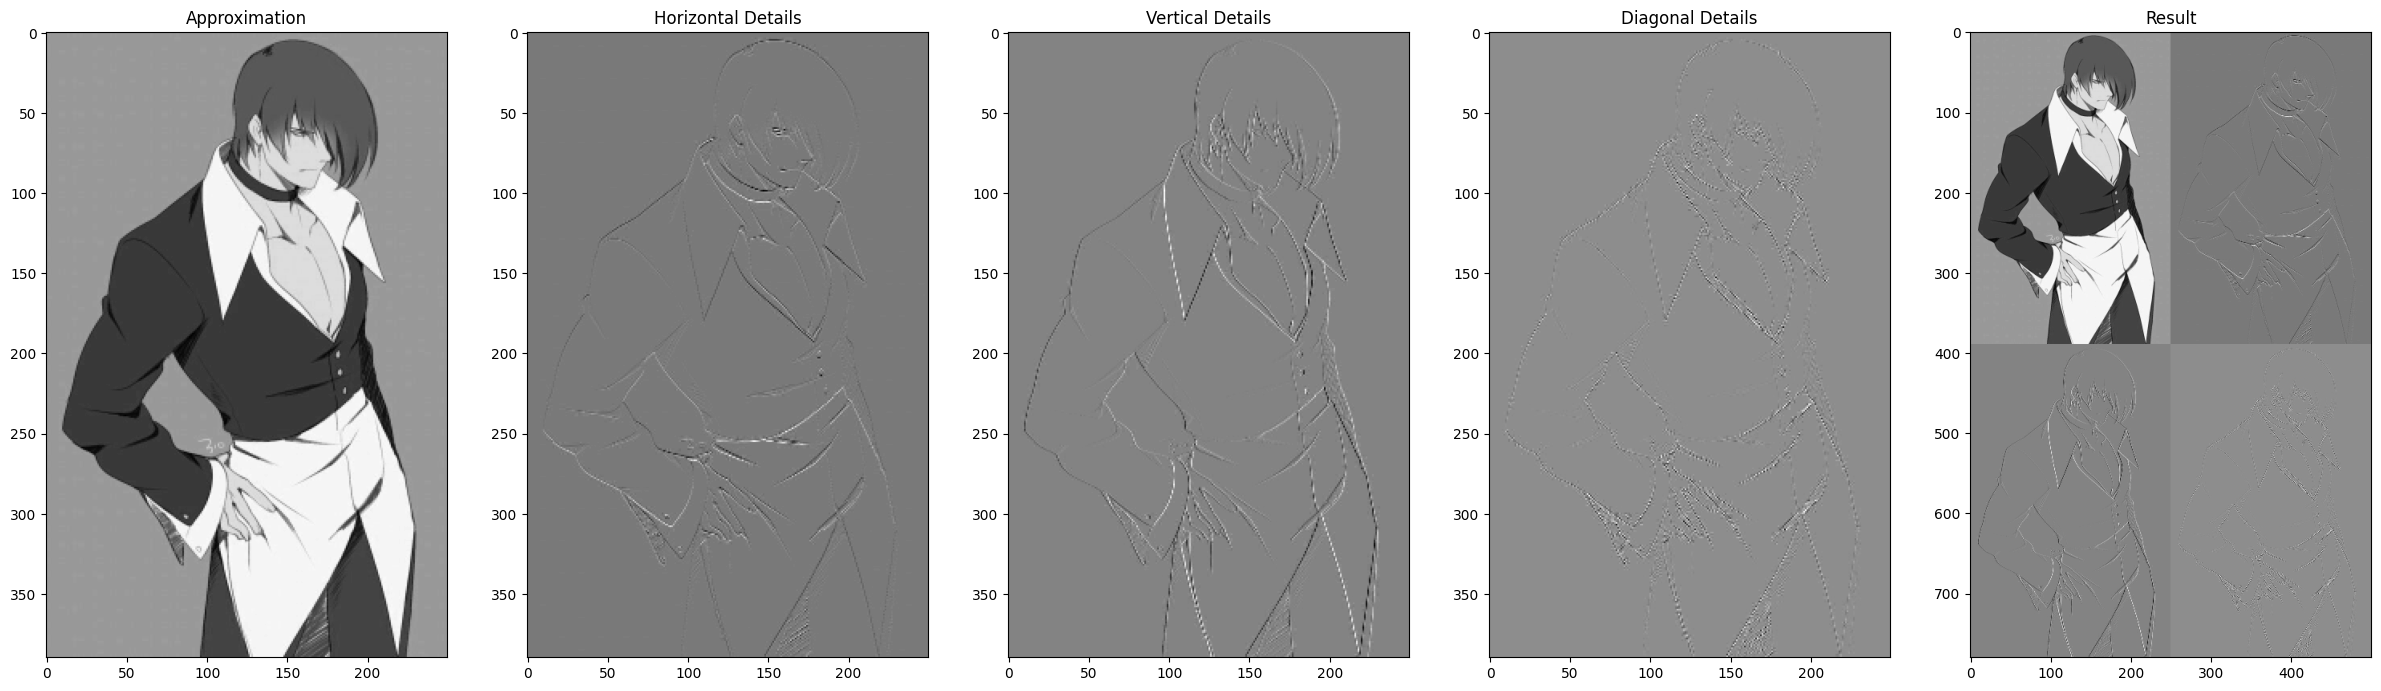

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(30, 30))

axs[0].imshow(ll, cmap='gray')
axs[0].set_title('Approximation')

axs[1].imshow(lh, cmap='gray')
axs[1].set_title('Horizontal Details')

axs[2].imshow(hl, cmap='gray')
axs[2].set_title('Vertical Details')

axs[3].imshow(hh, cmap='gray')
axs[3].set_title('Diagonal Details')

axs[4].imshow(comb, cmap='gray')
axs[4].set_title('Result')

plt.show()

## Melakukan rekonstruksi citra berdasarkan hasil dekomposisi

In [17]:
result = rekonstruksi(ll, lh, hl, hh)

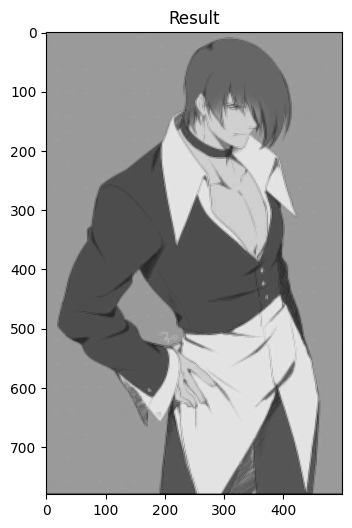

In [18]:
fig, axs = plt.subplots(figsize=(6, 6))

axs.imshow(result, cmap='gray')
axs.set_title('Result')
plt.show()


## Melakukan Dekomposisi pada level 4 secara dinamis


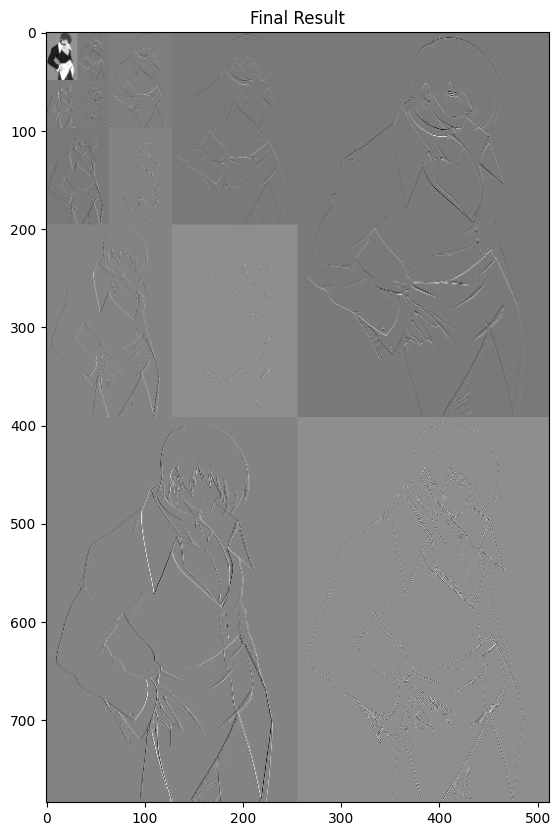

In [19]:
padded_image = pad_image(image, 4)

_, _, _, _, result = dekomposisi_wavelet(padded_image, 4)

fig, axs = plt.subplots(figsize=(10, 10))

axs.imshow(result, cmap='gray')
axs.set_title('Final Result')

plt.show()

## Pada level berapa hasil dari dekomposisi berdasarkan citra pada soal? berikan alasannya

In [20]:
ll, lh, hl, hh, _ = dekomposisi_wavelet_level(image, 6)

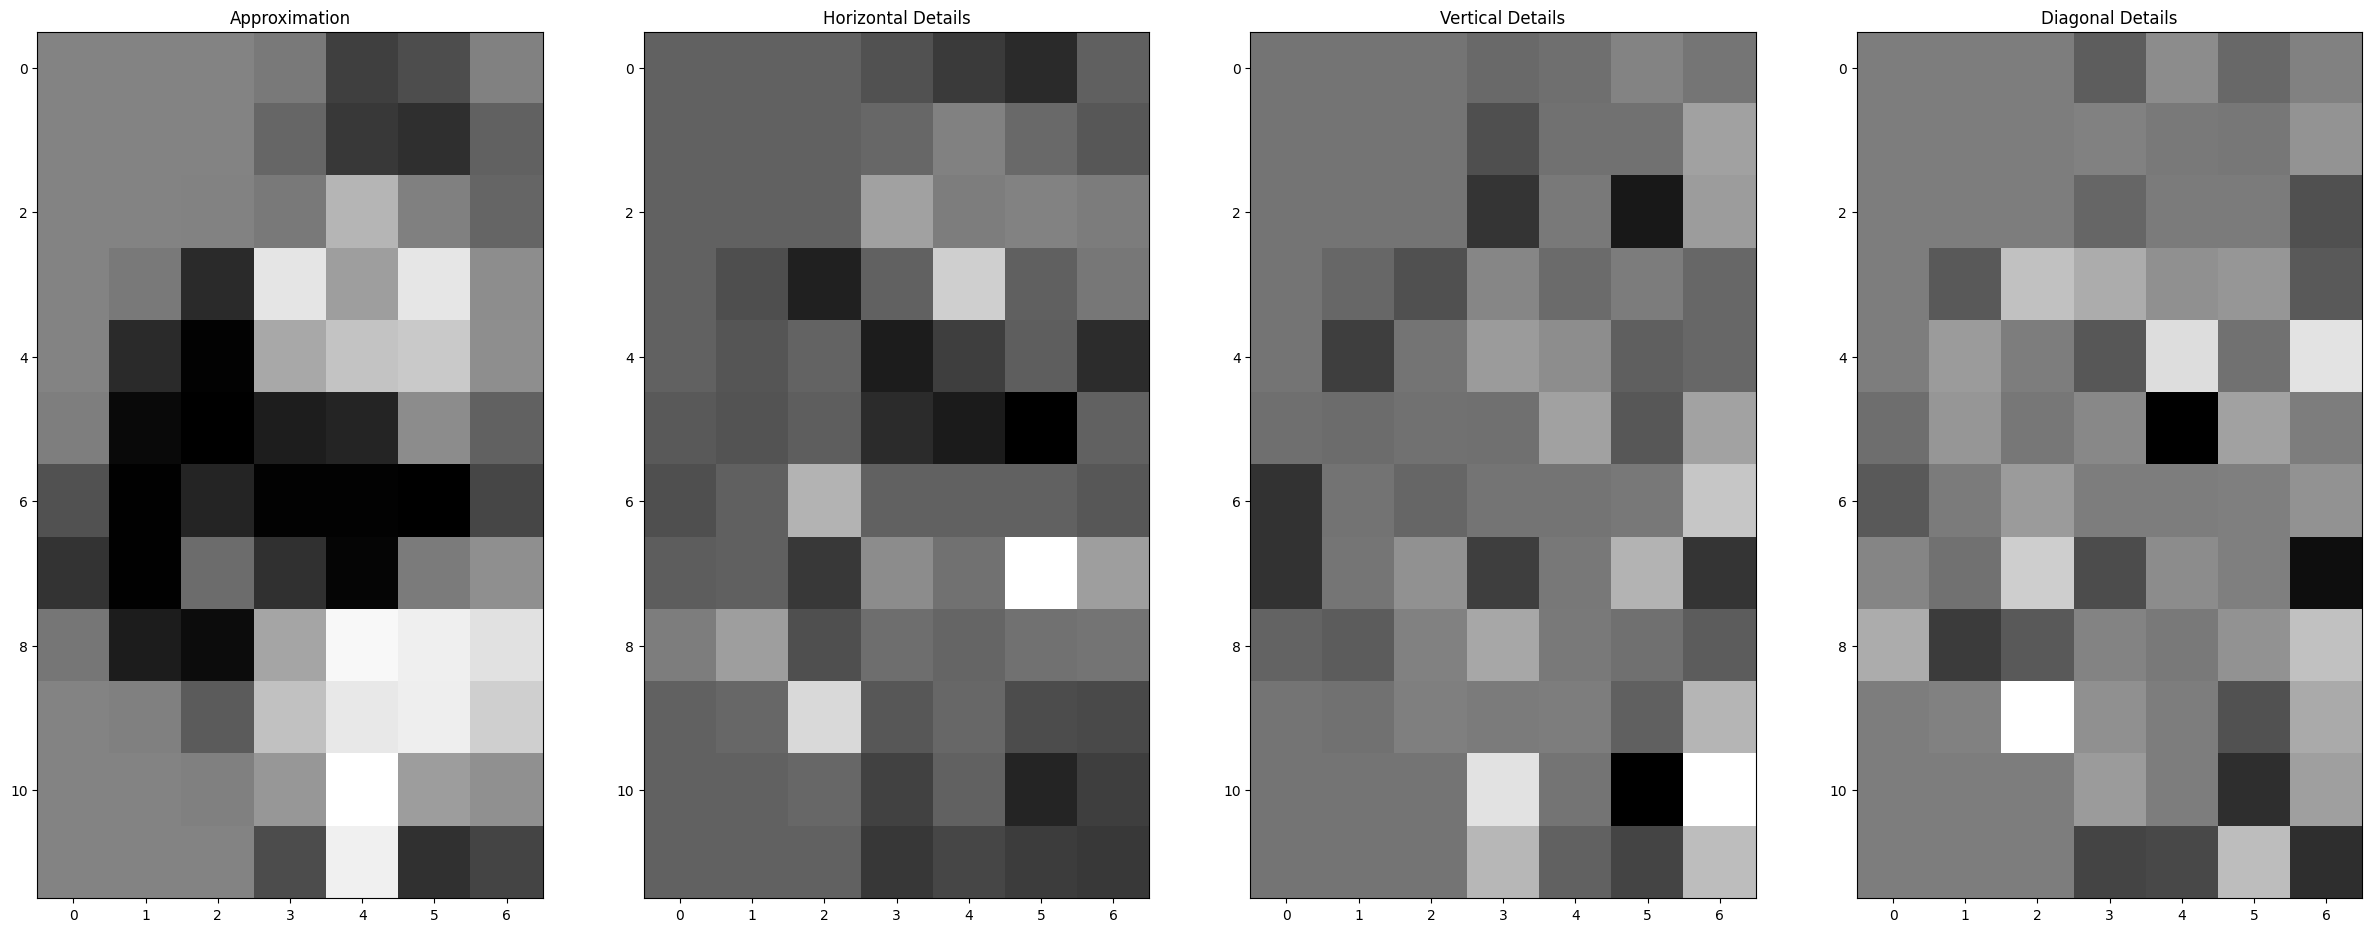

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(30, 30))

axs[0].imshow(ll, cmap='gray')
axs[0].set_title('Approximation')

axs[1].imshow(lh, cmap='gray')
axs[1].set_title('Horizontal Details')

axs[2].imshow(hl, cmap='gray')
axs[2].set_title('Vertical Details')

axs[3].imshow(hh, cmap='gray')
axs[3].set_title('Diagonal Details')

plt.show()

## Menampilkan representasi sinyal citra

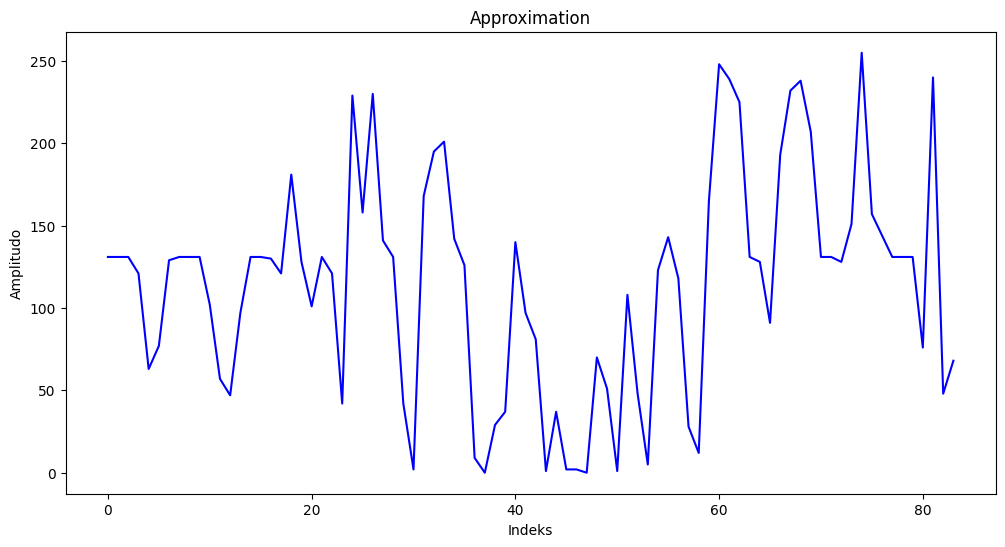

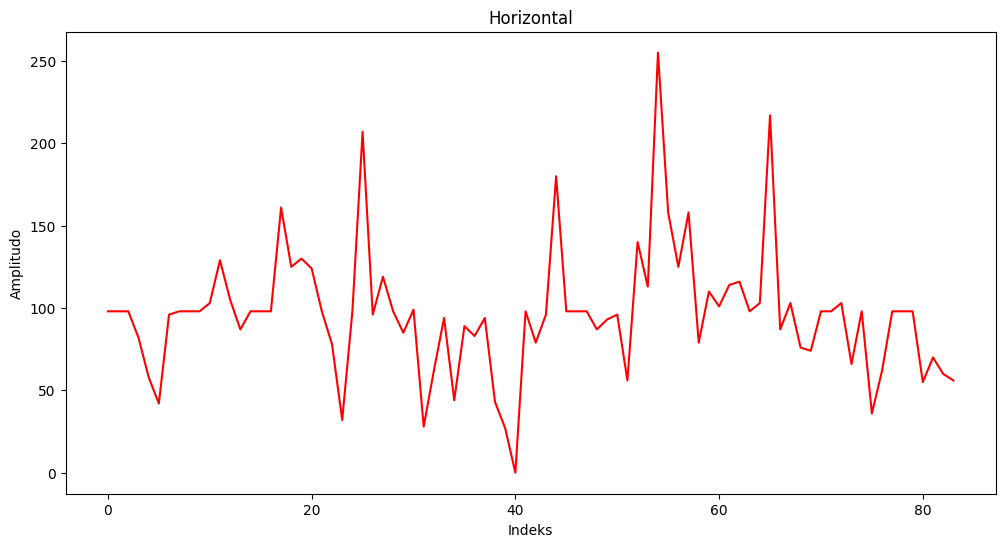

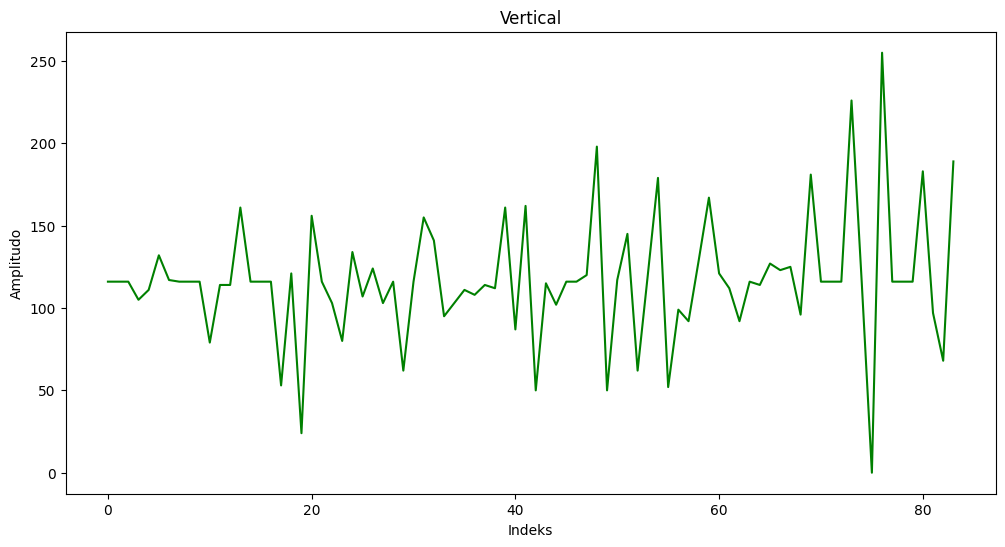

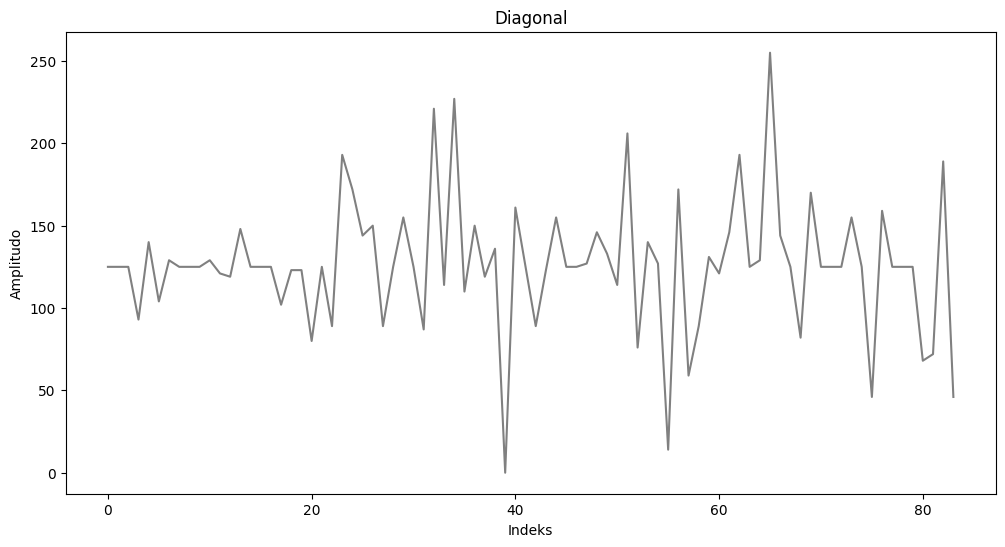

In [22]:
plot_sinyal(ll, 'Approximation')
plot_sinyal(lh, 'Horizontal', 'r')
plot_sinyal(hl, 'Vertical', 'g')
plot_sinyal(hh, 'Diagonal', 'gray')